# Neural Networks tutorial 02
## **UNet** for segmentation and as a deep image prior

This tutorial demonstrates how to build and train a U-Net style convolutional neural network (CNN) for three tasks:

1. **Semantic Segmentation**: Distinguish foreground objects from background (binary classification per pixel)
2. **Instance Segmentation**: Separate individual objects even when they overlap  
3. **Deep Image Prior**: Use the network as an image generator for super-resolution as a demonstration of a self-supervised learning worfklow. 

We'll also cover **model checkpointing**: how to save and reload trained models to resume training later.


## Requirements
- [scikit-learn](https://scikit-learn.org/stable/) for clustering algorithms
- GPU recommended (training is slow on CPU alone, though Apple Silicon/MPS also works well)

Arthur McCray  
Jan 6, 2026


In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.auto import tqdm

from quantem.core import config
from quantem.core.ml import CNN2d
from quantem.core.visualization import show_2d

from importlib.metadata import version # Temporary fix for version check
print(f"quantEM version: {version("quantem")}")

print(f"Torch cuda is available: {torch.cuda.is_available()}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")
GPU_ID = 0

config.set_device(GPU_ID)
print(f"Using GPU {config.get('device')} ({torch.cuda.get_device_name(GPU_ID)})")

/home/amccray/code/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


quantEM version: 0.1.7
Torch cuda is available: True
Number of GPUs available: 4
Using GPU cuda:0 (NVIDIA L40S)


## Shared Data Generation Functions

These functions create synthetic training data used in both semantic and instance segmentation sections.


In [3]:
from skimage.draw import random_shapes

def make_data(
    image_shape=(128, 128),
    n_images=10,
    max_shapes=6,
    min_shapes=2,
    allow_overlap=False,
    rng=None,
    instance=False,
):
    """Generate synthetic dataset of random shapes.
    
    Args:
        image_shape: Size of generated images (height, width)
        n_images: Number of images to generate
        max_shapes/min_shapes: Range of shapes per image
        allow_overlap: Whether shapes can overlap each other
        rng: Random number generator for reproducibility
        instance: If True, label each object separately; if False, create binary mask
    
    Returns:
        images: Array of shape (N, 1, H, W) - the "1" is the channel dimension
        labels: Array of shape (N, 1, H, W) with semantic or instance labels
    """
    images = []
    labels = []

    for _ in tqdm(range(n_images)):
        # Generate random shapes using scikit-image
        img, lbl = random_shapes(
            image_shape,
            max_shapes=max_shapes,
            min_shapes=min_shapes,
            num_channels=1,
            min_size=10,
            allow_overlap=allow_overlap,
            rng=rng,
            intensity_range=(0, 200),
        )
        img = img.squeeze()
        
        # Create labels: either per-instance IDs or binary mask
        if instance:
            label = np.zeros_like(img)
            for i, val in enumerate(np.unique(img)):
                if val == 255:  # 255 is background
                    continue
                label[img == val] = min(i+5, 255)
        else:
            # Binary mask: 0 = background (255), 1 = object (anything else)
            label = np.array(img != 255).astype(np.uint8)
            
        # Normalize images to [0, 1] range (standard for neural networks)
        img -= img.min()
        img = img / img.max()

        images.append(img[None, ...])  # Add channel dimension: (H,W) -> (1,H,W)
        labels.append(label[None,])

    images = np.stack(images, axis=0)  # Stack into (N, 1, H, W)
    labels = np.stack(labels, axis=0)  # Stack into (N, 1, H, W)
    return images, labels


# Part 1: Semantic Segmentation

**Goal**: Train a neural network to distinguish objects from background at the pixel level.

In semantic segmentation, every pixel gets classified into a category. For this tutorial, we'll keep it simple with just two categories: "object" (1) or "background" (0). This is called binary segmentation.

### 1.0 Helper functions for semantic segmentation

In [4]:
class SimpleDataset(Dataset):
    """PyTorch Dataset wrapper for image-label pairs.
    
    PyTorch uses Dataset objects to organize training data. This class takes
    numpy arrays and converts them to PyTorch tensors when requested.
    """
    def __init__(self, dps, labels):
        # Convert numpy arrays to PyTorch tensors
        self.dps = [torch.tensor(dp, dtype=torch.float32) for dp in dps]
        self.labels = [torch.tensor(lbl, dtype=torch.float32) for lbl in labels]

    def __len__(self):
        return len(self.dps)

    def __getitem__(self, idx):
        """Return one image-label pair."""
        return self.dps[idx], self.labels[idx]



def noise_image(image, noise_level=0.1, rng=None):
    """Add Gaussian noise to make training more robust."""
    if rng is None:
        rng = np.random.default_rng()

    noise = rng.normal(0, noise_level, image.shape).astype(image.dtype)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)  # Keep values in valid range
    return noisy_image

def augment_dataset(
    images, labels, augment_factor=2, noise_level=0.0, rng=None, flip=True, rotate=True
):
    """Expand dataset with random transformations.
    
    Data augmentation helps neural networks generalize better by showing them
    variations of the same image (rotated, flipped, noisy versions).
    
    Args:
        images, labels: Input data arrays
        augment_factor: How many augmented copies to make per image
        noise_level: Standard deviation of Gaussian noise to add
        flip, rotate: Whether to apply these transformations
    """
    augmented_images = []
    augmented_labels = []
    if rng is None:
        rng = np.random.default_rng()

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        for _ in range(augment_factor):
            img_aug = img.copy()
            lbl_aug = lbl.copy()
            
            if rotate:
                # Random 90-degree rotations (0, 90, 180, or 270 degrees)
                n_rot = int(rng.integers(0, 4))
                img_aug = np.rot90(img, k=n_rot, axes=(-2, -1))
                lbl_aug = np.rot90(lbl, k=n_rot, axes=(-2, -1))
                
            if flip:
                if rng.random() > 0.5:  # 50% chance of horizontal flip
                    img_aug = np.flip(img_aug, axis=-1)
                    lbl_aug = np.flip(lbl_aug, axis=-1)

                if rng.random() > 0.5:  # 50% chance of vertical flip
                    img_aug = np.flip(img_aug, axis=-2)
                    lbl_aug = np.flip(lbl_aug, axis=-2)

            if noise_level > 0:
                img_aug = noise_image(img_aug, noise_level=noise_level, rng=rng)

            augmented_images.append(img_aug)
            augmented_labels.append(lbl_aug)

    augmented_images = np.stack(augmented_images, axis=0)
    augmented_labels = np.stack(augmented_labels, axis=0)

    return augmented_images, augmented_labels


## 1.1 Generate Training Data

We'll create 500 images, each with random shapes. The neural network will learn to predict which pixels belong to shapes (foreground) versus background.

100%|██████████| 500/500 [00:00<00:00, 874.40it/s]


images shape (N, channel, H, W): (500, 1, 128, 128)
labels shape (N, 1, H, W): (500, 1, 128, 128)


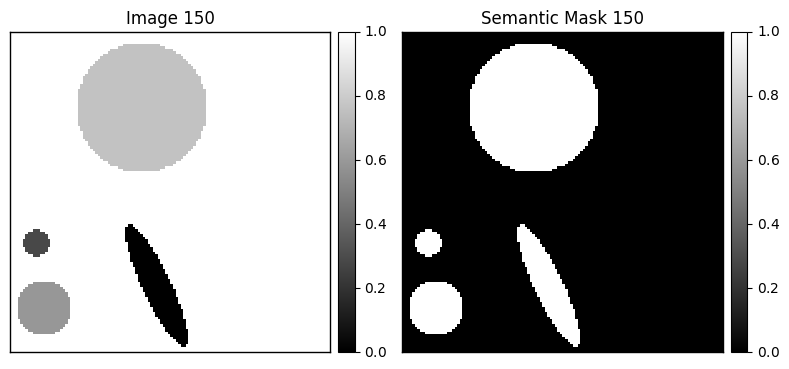

In [5]:
image_shape = (128, 128)
n_images = 500
rng_seed = 42

rng = np.random.default_rng(rng_seed)
rng_torch = torch.Generator().manual_seed(rng_seed)

images, labels = make_data(
    image_shape=image_shape, n_images=n_images, allow_overlap=False, rng=rng, instance=False
)

print("images shape (N, channel, H, W):", images.shape)
print("labels shape (N, 1, H, W):", labels.shape)

i = 150
show_2d(
    [
        images[i].squeeze(),
        labels[i].squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Image {i}", f"Semantic Mask {i}"],
);

## 1.2 Data Augmentation

Data augmentation is a technique to artificially expand your training set by creating variations of existing images (rotations, flips, noise). This helps the network learn more general patterns.

In this example, we're not actually augmenting (we set `augment_factor=1`), but we do add some noise. In practice, you'd increase `augment_factor` to 2 or 3 when you have limited training data, but you also have to be careful to not include augmented versions of the same base data in both your training and validation sets. 

**Note:** Augmentation can also be done "on-the-fly" in the DataLoader (shown later), which is often more efficient.

100%|██████████| 500/500 [00:00<00:00, 4895.93it/s]


Final augmented dataset shape: (500, 1, 128, 128), labels shape: (500, 1, 128, 128)


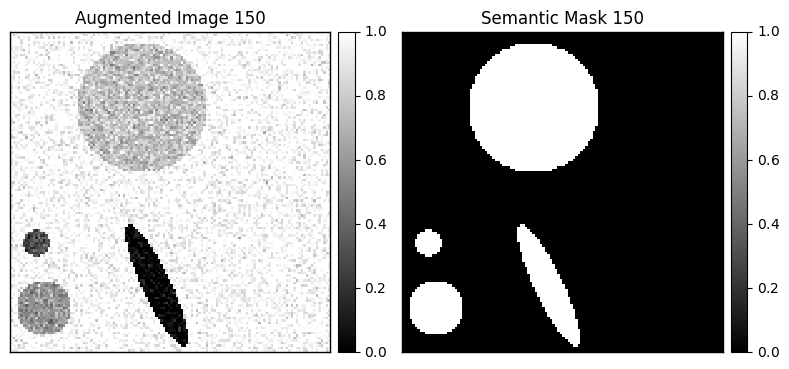

In [6]:
# augment_factor=1 means we don't multiply the dataset (no flips/rotations applied)
# Setting augment_factor=2 would double the dataset size with transformed versions
# We add noise (noise_level=0.1) to make the network more robust to variations
augment_factor = 1

augmented_images, augmented_labels = augment_dataset(
    images, labels, augment_factor=augment_factor, noise_level=0.1, rng=rng, flip=False, rotate=False
)

print(
    f"Final augmented dataset shape: {augmented_images.shape}, labels shape: {augmented_labels.shape}"
)

show_2d(
    [
        augmented_images[i].squeeze(),
        augmented_labels[i].squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Augmented Image {i}", f"Semantic Mask {i}"],
);

## 1.3 Prepare PyTorch DataLoaders

1. **Train/Validation Split**: We separate data into training (80%) and validation (20%) sets
   - Training set: Used to update the network weights
   - Validation set: Used to check if the network generalizes (not used for training)
   
2. **Batching**: Instead of feeding one image at a time, we group them into batches
   - `batch_size=32` means we process 32 images simultaneously
   - This speeds up training on GPUs and provides more stable gradient updates

In [7]:
# Wrap data in a PyTorch Dataset
dataset = SimpleDataset(augmented_images, augmented_labels)

# Split: 80% training, 20% validation
val_factor = 0.2
train_size = int((1 - val_factor) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=rng_torch)

print(f"Length of train dataset: {len(train_dataset)} | validation dataset: {len(val_dataset)}")

# Create DataLoaders (handle batching and shuffling)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)    # Don't shuffle validation
print(f"Train loader batches: {len(train_loader)} | Validation loader batches: {len(val_loader)}")

Length of train dataset: 400 | validation dataset: 100
Train loader batches: 13 | Validation loader batches: 4


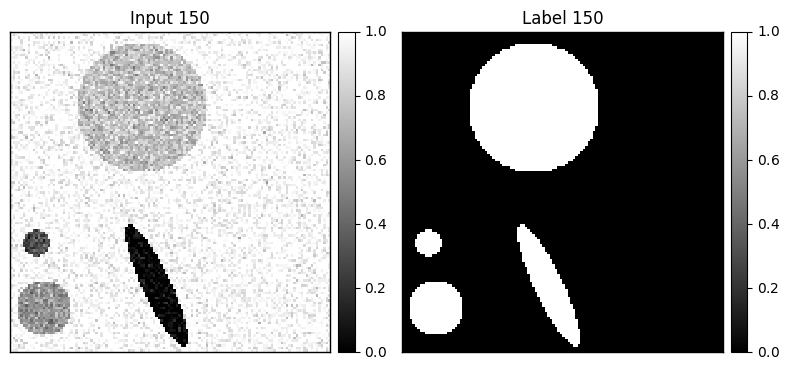

In [8]:
# Verify the dataset works by getting one example
# The dataset returns PyTorch tensors ready for training
i = 150
input, label = dataset[i]
show_2d(
    [
        input.squeeze(),
        label.squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Input {i}", f"Label {i}"],
);

## 1.4 Create and train the neural network

Now we set up the key components for training:

1. **Model**: A U-Net CNN that takes 1-channel images and outputs 1-channel predictions
2. **Optimizer**: AdamW algorithm that updates network weights based on gradients
3. **Loss Function**: Binary Cross-Entropy (BCE) measures how different predictions are from true labels
4. **Scheduler**: Gradually reduces learning rate during training for better convergence

In [9]:
# Running this cell resets the model and optimizer, effectively restarting the training process

# Create a U-Net model
model = CNN2d(
    in_channels=1,                          # 1 input channel (grayscale images)
    out_channels=1,                         # 1 output channel (binary classification)
    final_activation=torch.nn.Sigmoid(),    # Sigmoid sets output range to [0,1] for binary classification
)
model = model.to(config.get_device())  # Move model to GPU if available

# Optimizer: adjusts weights to minimize loss
# Learning rate scales with sqrt(batch_size) - larger batches need higher learning rates
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4 * np.sqrt(batch_size))

# Loss function: measures prediction error
# BCELoss (Binary Cross-Entropy) is standard for binary classification
criterion = torch.nn.BCELoss()

# Learning rate scheduler: gradually reduces learning rate for fine-tuning
# gamma=0.999 means multiply learning rate by 0.999 each epoch
# this does not have much of an effect on training here, but is meant as a demonstration of the concept
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# Track losses during training
train_losses = []
val_losses = []
lrs = [] 

100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


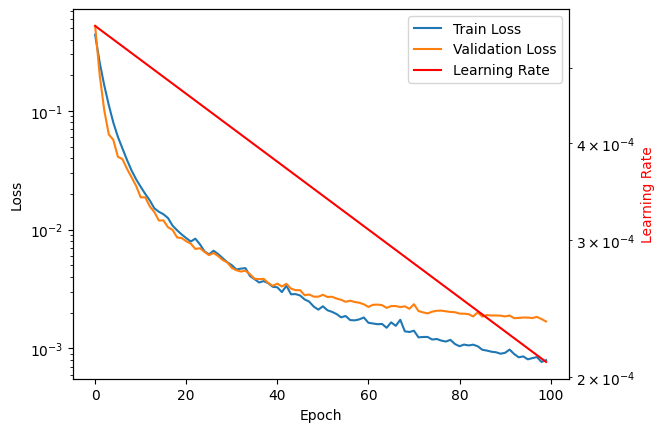

In [10]:
### Training Loop:
# this cell can be run multiple times for additional training

# Train for 100 epochs (one epoch = one pass through all training data)
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    ### TRAINING PHASE
    model.train()  # Set model to training mode (enables dropout, batch norm updates, etc.)
    epoch_loss = 0
    
    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(config.get_device()), targets.to(config.get_device())

        # Standard PyTorch training steps:
        optimizer.zero_grad()         # 1. Clear old gradients
        outputs = model(inputs)       # 2. Forward pass: compute predictions
        loss = criterion(outputs, targets)  # 3. Compute loss
        loss.backward()               # 4. Backward pass: compute gradients
        optimizer.step()              # 5. Update weights

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    ### VALIDATION PHASE
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    with torch.no_grad():  # Don't compute gradients for validation (saves memory)
        val_loss = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(config.get_device()), targets.to(config.get_device())

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
    
    # Update learning rate once per epoch
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()


# Plot the training and validation losses, and the learning rate
fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax2 = ax.twinx()
ax2.semilogy(lrs, c='r', label="Learning Rate")
ax2.set_ylabel("Learning Rate", color='r')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)
plt.show()

You can re-run the training cell above multiple times to continue training. The model will keep improving from where it left off. 

### Understanding the Loss Curves

**What to look for:**
- **Both losses decreasing**: The model is learning!
- **Gap between train and validation**: The model fits training data better than validation data
  - Small gap: Good generalization
  - Large gap: Possible overfitting (model memorizes training data instead of learning patterns)
  
In this example, you'll see some separation between curves. This suggests mild overfitting, though validation loss still improves.

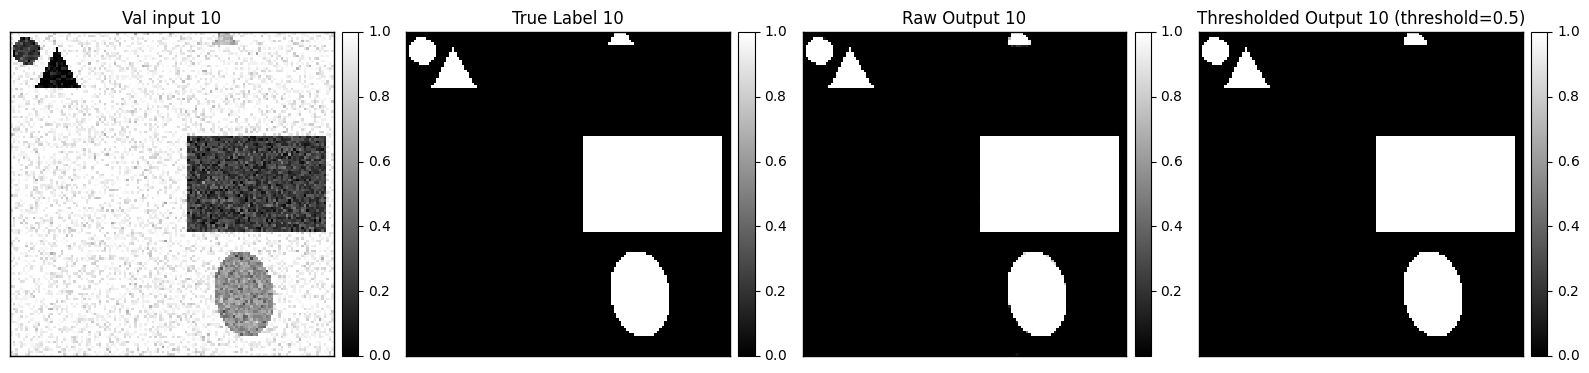

In [11]:
### Test the Trained Model

# Let's see how well the model performs on a validation example
i = 10
thresh_val = 0.5

inp, lab = val_dataset[i]
# Forward pass: add batch dimension with [None, ...], move to GPU, then back to CPU for visualization
out = model(inp[None, ...].to(config.get_device())).squeeze().cpu().detach().numpy()

# Apply threshold to get binary prediction
# Network outputs probabilities [0,1]; we threshold at 0.5 for final decision
thresh = (out > thresh_val).astype(np.float32)

show_2d(
    [
        inp.squeeze(),
        lab.squeeze(),
        out.squeeze(),
        thresh.squeeze(),
    ],
    cbar=True,
    norm="minmax",
    title=[f"Val input {i}", f"True Label {i}", f"Raw Output {i}", f"Thresholded Output {i} (threshold={thresh_val})"],
);


# Part 2: Instance Segmentation

**Challenge**: Separate individual objects even when they overlap.

Semantic segmentation (above) only tells us "object vs background." Instance segmentation goes further: it identifies *each separate object*.


### 2.0 Helper functions for instance segmentation

These functions convert the multi-channel network predictions into instance labels by grouping pixels that belong to the same object.


In [12]:
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.cluster import DBSCAN, MeanShift


def dbscan_clustering(nn_output, semantic_threshold=0.5, eps=1.0, min_samples=10):
    """Convert network predictions to instance labels using DBSCAN clustering.
    
    Uses predicted offset vectors to cluster pixels that point to the same object center.
    """
    semantic, offset_row, offset_col = nn_output[0], nn_output[2], nn_output[3]
    H, W = semantic.shape

    # Only consider foreground pixels
    fg_mask = semantic > semantic_threshold
    fg_coords = np.where(fg_mask)

    if len(fg_coords[0]) == 0:
        return np.zeros((H, W), dtype=np.int32)

    # Each pixel's position plus its offset vector gives target position
    pixel_positions = np.column_stack([fg_coords[1], fg_coords[0]])
    offset_vectors = np.column_stack([offset_col[fg_coords], offset_row[fg_coords]])
    target_positions = pixel_positions + offset_vectors

    # Cluster pixels that point to similar locations
    cluster_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(target_positions)

    # Map cluster labels back to image coordinates
    instance_map = np.zeros((H, W), dtype=np.int32)
    valid_pixels = cluster_labels >= 0  # DBSCAN labels noise as -1
    if np.any(valid_pixels):
        instance_map[fg_coords[0][valid_pixels], fg_coords[1][valid_pixels]] = (
            cluster_labels[valid_pixels] + 1
        )

    return instance_map


def meanshift_clustering(nn_output, semantic_threshold=0.5, bandwidth=10.0):
    """Convert network predictions to instance labels using Mean Shift clustering.
    
    Alternative to DBSCAN that automatically finds cluster centers.
    """
    semantic, offset_row, offset_col = nn_output[0], nn_output[2], nn_output[3]
    H, W = semantic.shape

    fg_mask = semantic > semantic_threshold
    fg_coords = np.where(fg_mask)

    if len(fg_coords[0]) == 0:
        return np.zeros((H, W), dtype=np.int32)

    pixel_positions = np.column_stack([fg_coords[1], fg_coords[0]])
    offset_vectors = np.column_stack([offset_col[fg_coords], offset_row[fg_coords]])
    target_positions = pixel_positions + offset_vectors

    cluster_labels = MeanShift(bandwidth=bandwidth).fit_predict(target_positions)

    instance_map = np.zeros((H, W), dtype=np.int32)
    instance_map[fg_coords[0], fg_coords[1]] = cluster_labels + 1

    return instance_map


def watershed_clustering(
    nn_output, semantic_threshold=0.5, center_threshold=0.3, use_distance_map=False, min_distance=5
):
    """Convert network predictions to instance labels using Watershed algorithm.
    
    Uses predicted centers as seeds and offset magnitude as the "height map" for watershed.
    Works well when objects don't overlap too much.
    """
    semantic, centers, offset_row, offset_col = (
        nn_output[0],
        nn_output[1],
        nn_output[2],
        nn_output[3],
    )
    H, W = semantic.shape

    fg_mask = semantic > semantic_threshold
    if not np.any(fg_mask):
        return np.zeros((H, W), dtype=np.int32)

    # Find peaks in center prediction as object seeds
    center_peaks = peak_local_max(
        centers, min_distance=min_distance, threshold_abs=center_threshold
    )

    if len(center_peaks[0]) == 0:
        return ndi.label(fg_mask)[0]

    # Create seed points for watershed
    seeds = np.zeros((H, W), dtype=np.int32)
    for i, (row, col) in enumerate(center_peaks):
        seeds[row, col] = i + 1

    # Create "surface" for watershed to flow along
    if use_distance_map:
        surface = -1 * distance_transform_edt(fg_mask)
    else:
        # Use offset magnitude: higher near boundaries
        offset_magnitude = np.sqrt(offset_row**2 + offset_col**2)
        surface = offset_magnitude
        surface[~fg_mask] = surface.max()

    return watershed(surface, seeds, mask=fg_mask)


## 2.1 Generate Training Data with Overlaps

Key difference from semantic segmentation:
- allow_overlap=True: Shapes can now overlap, making this much harder
- instance=True: Each object gets a unique label (not just foreground/background)
- More data needed: 20,000 images (vs 500 before) because this task is harder


100%|██████████| 20000/20000 [00:08<00:00, 2315.92it/s]


images shape: (20000, 1, 64, 64)
instance_masks shape: (20000, 64, 64)


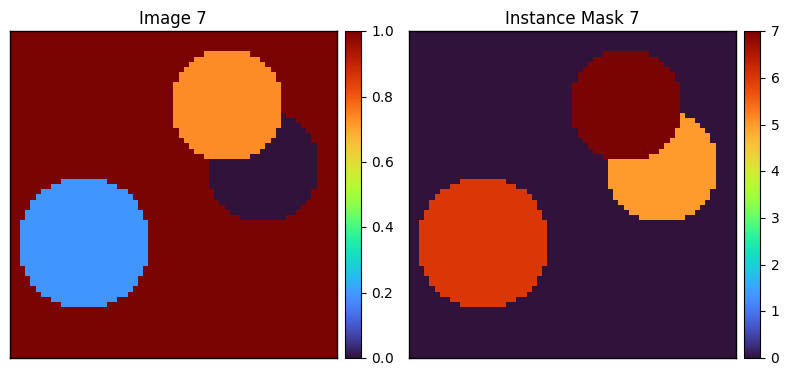

In [13]:
image_shape = (64, 64)
n_images = 20_000
rng_seed = 42

rng = np.random.default_rng(rng_seed)
rng_torch = torch.Generator().manual_seed(rng_seed)

images, instance_masks = make_data(
    min_shapes=2,
    max_shapes=6,
    image_shape=image_shape,
    n_images=n_images,
    allow_overlap=True,      # Objects can overlap now
    rng=rng,
    instance=True,           # Each object gets unique ID
)
instance_masks = instance_masks.squeeze()

print("images shape:", images.shape)
print("instance_masks shape:", instance_masks.shape)

i = 7
show_2d(
    [
        images[i].squeeze(),
        instance_masks[i],
    ],
    cbar=True,
    norm="minmax",
    title=[f"Image {i}", f"Instance Mask {i}"],
    cmap='turbo'
);

## 2.2 Create Training Targets

We now have instance labels (each object has a unique ID). However, we won't train the network to predict these IDs directly. Instead, we'll train it to predict "helper" outputs that can be converted to instance labels via clustering.

Specifically, the network predicts four output channels:
1. **Semantic Mask**: Binary mask (0=background, 1=foreground)
2. **Center Heatmap**: Bright spots at object centers (helps identify separate objects)
3. **Offset Y**: For each pixel, how many pixels up/down to the object's center
4. **Offset X**: For each pixel, how many pixels left/right to the object's center

We then use clustering algorithms to group pixels that belong to the same object based on these outputs. This solves the issue of the network not knowing in advance how many objects are in an image. 

Next, we convert instance labels into the training targets our network will learn.

In [14]:
def generate_training_targets(instance_labels, sigma_center=1):
    """Convert instance labels to training targets for the multi-head network.

    Args:
        instance_labels: (H, W) array where 0=background, 1=obj1, 2=obj2, etc.
        sigma_center: Width of Gaussian peaks for center heatmap

    Returns:
        (4, H, W) array with channels:
        0. Semantic mask: binary foreground/background
        1. Center heatmap: Gaussian peaks at object centers
        2. Offset Y: vertical distance from each pixel to its object's center
        3. Offset X: horizontal distance from each pixel to its object's center
    """
    H, W = instance_labels.shape

    # Channel 0: Binary semantic mask (any object = 1, background = 0)
    semantic_mask = (instance_labels > 0).astype(np.float32)

    offset_field = np.zeros((2, H, W), dtype=np.float32)
    center_heatmap = np.zeros((H, W), dtype=np.float32)
    instance_ids = np.unique(instance_labels)[1:]  # Skip background (0)

    if len(instance_ids) == 0:
        return np.stack([semantic_mask, center_heatmap, offset_field[0], offset_field[1]])

    # Create coordinate grids
    y_grid, x_grid = np.mgrid[0:H, 0:W]
    
    # Process each object separately
    for instance_id in instance_ids:
        instance_mask = instance_labels == instance_id
        
        # Find this object's center
        center_y, center_x = ndi.center_of_mass(instance_mask)
        
        # Channels 2-3: Offset vectors point from each pixel to its object's center
        dy = center_y - y_grid
        dx = center_x - x_grid
        offset_field[0][instance_mask] = dy[instance_mask]
        offset_field[1][instance_mask] = dx[instance_mask]

        # Channel 1: Add Gaussian peak at this object's center
        dist_sq = (x_grid - center_x) ** 2 + (y_grid - center_y) ** 2
        gaussian = np.exp(-dist_sq / (2 * sigma_center**2))
        center_heatmap = np.maximum(center_heatmap, gaussian)  # Take max for overlaps
        
    return np.stack([semantic_mask, center_heatmap, offset_field[0], offset_field[1]])

(4, 64, 64)


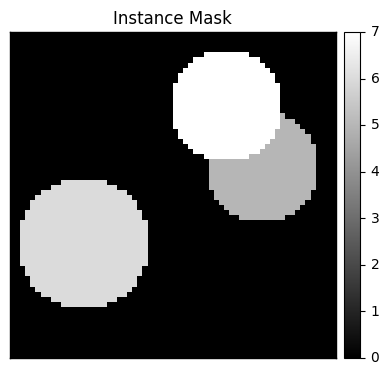

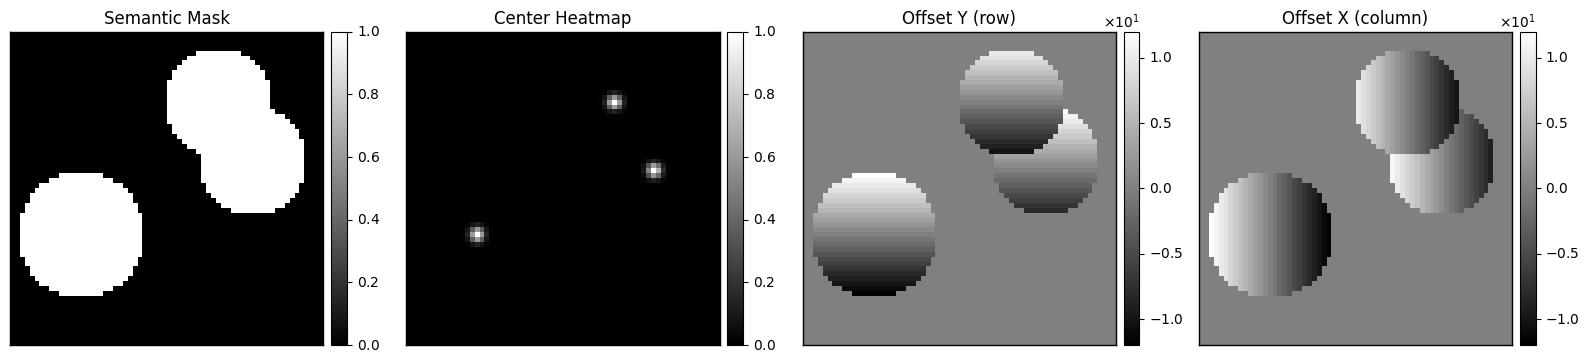

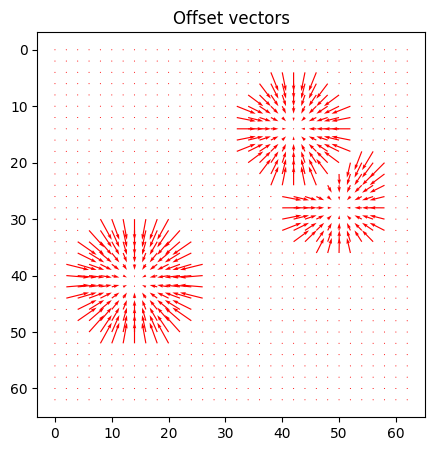

In [15]:
# Generate targets
i = 7
targets = generate_training_targets(instance_masks[i])

print(targets.shape)

show_2d(instance_masks[i], cbar=True, norm="minmax", title="Instance Mask")

show_2d(
    [
        targets[0],
        targets[1],
        targets[2],
        targets[3],
    ],
    cbar=True,
    norm="minmax",
    title=[
        "Semantic Mask",
        "Center Heatmap",
        "Offset Y (row)",
        "Offset X (column)",
    ],
)

fig, ax = plt.subplots(figsize=(5, 5))
offset_y = targets[2]
offset_x = targets[3]
step = 2  # subsample for clarity
Y, X = np.mgrid[0:offset_y.shape[0], 0:offset_y.shape[1]]
ax.quiver(
    X[::step, ::step],
    Y[::step, ::step],
    offset_x[::step, ::step],
    offset_y[::step, ::step],
    color="red",
    angles="xy",
    scale_units="xy",
    scale=3,
    width=0.003,
)
ax.invert_yaxis()
ax.set_title("Offset vectors")
plt.show()

### Clustering Methods

After the network predicts the four channels, we use clustering to group pixels into instances. We include three algorithms as examples here: 

1. **DBSCAN**: Groups pixels based on density. Works well with overlaps but needs parameter tuning (`eps`, `min_samples`)
    - HDBSCAN can avoid the parameter tuning in some cases. 
2. **Mean Shift**: Similar to DBSCAN but automatically finds cluster centers. Requires `bandwidth` parameter
3. **Watershed**: Uses the center heatmap as seeds and "flows" along the offset surface. Fast and simple, but struggles with heavy overlaps

Let's visualize how each clustering method performs on the ground-truth targets:

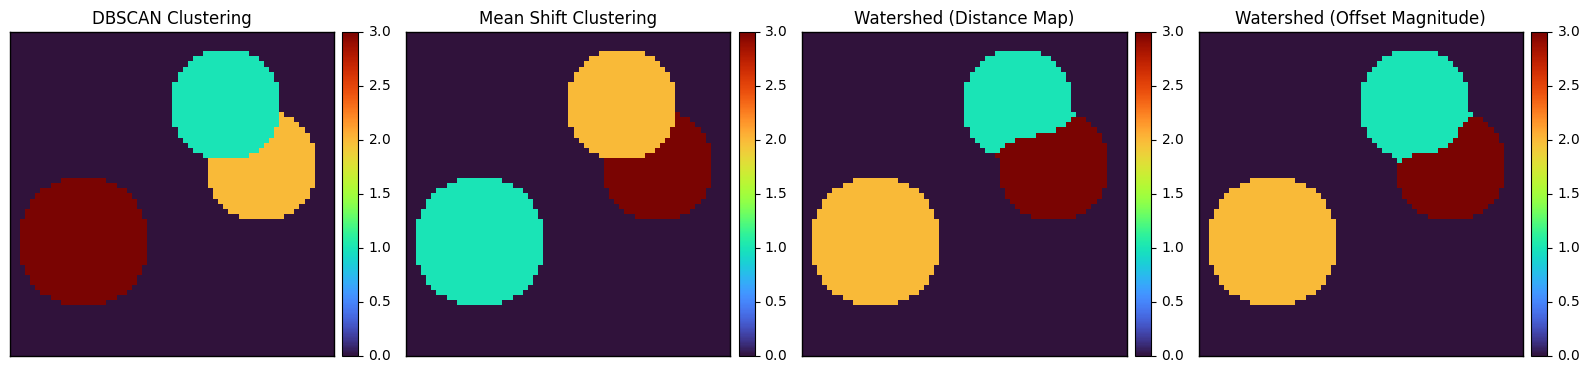

In [16]:
show_2d(
    [
        dbscan_clustering(targets),
        meanshift_clustering(targets),
        watershed_clustering(targets, use_distance_map=True),
        watershed_clustering(targets, use_distance_map=False),
    ],
    cbar=True,
    norm="minmax",
    title=[
        "DBSCAN Clustering",
        "Mean Shift Clustering",
        "Watershed (Distance Map)",
        "Watershed (Offset Magnitude)",
    ],
    cmap="turbo",
);

## 2.3 Create Dataset with on-the-fly augmentation

In [17]:
# First Transform all 20,000 instance masks into the 4-channel training targets
labels = []
for m in tqdm(instance_masks):
    labels.append(generate_training_targets(m))

100%|██████████| 20000/20000 [00:07<00:00, 2708.76it/s]


In [18]:
# This Dataset applies noise augmentation when data is requested (not pre-computed)
# This is allows us to have unlimited variations of the same base data, and saves memory
# compared to pre-computing an augmented dataset. 

class AugmentedDataset(Dataset):
    """Dataset that applies noise augmentation on-the-fly.
    
    Instead of pre-generating all augmented images, we add noise each time
    an image is requested. This saves memory and provides unlimited variations.
    We will 
    """
    def __init__(self, dps, labels, noise_level, rng=42):
        self.dps = [torch.tensor(dp, dtype=torch.float32) for dp in dps]
        self.labels = [torch.tensor(lbl, dtype=torch.float32) for lbl in labels]
        self.noise_level = noise_level
        self._torch_generator = torch.Generator().manual_seed(rng)

    def __len__(self):
        return len(self.dps)
        
    def _augment_image(self, image):
        """Add Gaussian noise to image."""
        noise = torch.normal(0, self.noise_level, image.shape, generator=self._torch_generator)
        noised_image = torch.clip(image + noise, 0, 1)
        return noised_image
        
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        """Return augmented image and its label."""
        dps, labels = self.dps[idx], self.labels[idx]
        augmented_dps = self._augment_image(dps)  # Apply noise on-the-fly
        return augmented_dps, labels


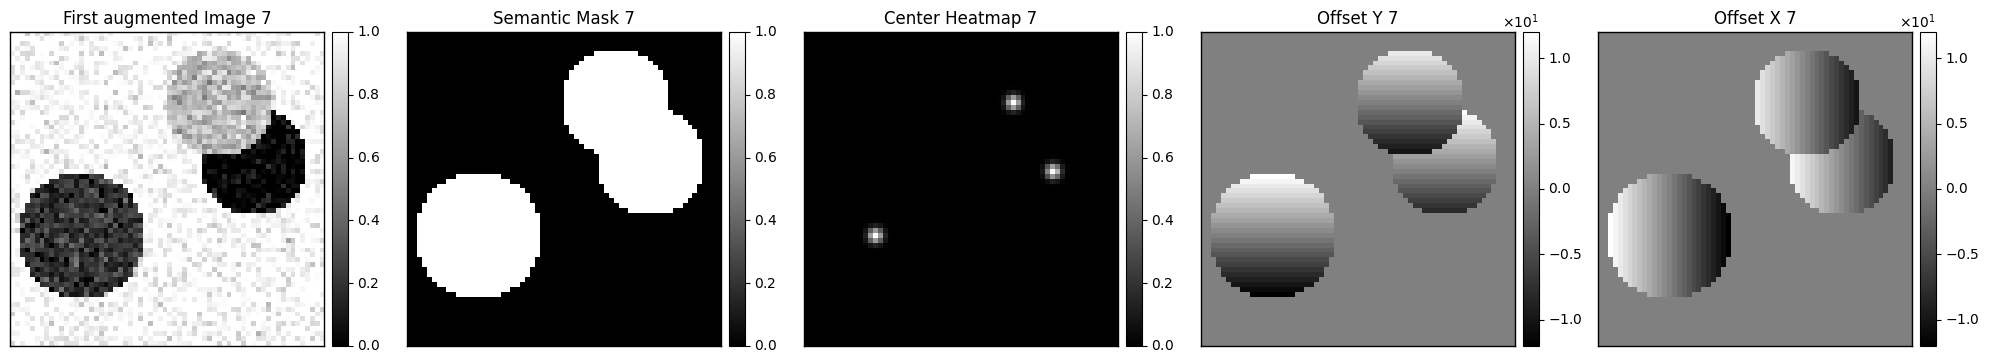

In [19]:
dataset = AugmentedDataset(images, labels, noise_level=0.1, rng=42)
i = 7

aug_image, aug_label = dataset[i]
show_2d(
    [
        aug_image.squeeze(),
        aug_label[0],
        aug_label[1],
        aug_label[2],
        aug_label[3],
    ],
    cbar=True,
    norm="minmax",
    title=[
        f"First augmented Image {i}",
        f"Semantic Mask {i}",
        f"Center Heatmap {i}",
        f"Offset Y {i}",
        f"Offset X {i}",
    ],
);

In [20]:
## Next create the dataLoaders

# Split: 80% training, 20% validation
val_factor = 0.2
train_size = int((1 - val_factor) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=rng_torch)

print(f"Length of train dataset: {len(train_dataset)} | validation dataset: {len(val_dataset)}")

# Create DataLoaders with larger batch size (128 vs 32 before)
# Larger batch sizes work well when you have lots of data and GPU memory
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Train loader batches: {len(train_loader)} | Validation loader batches: {len(val_loader)}")

Length of train dataset: 16000 | validation dataset: 4000
Train loader batches: 125 | Validation loader batches: 32


## 2.4 Multi-Channel Network Architecture and Loss Function

In [21]:
from quantem.core.ml.activation_functions import get_activation_function


class MultiChannelCNN2d(CNN2d):
    """U-Net with different activation functions for each output channel.

    This extends the base CNN2d to allow per-channel activations.
    """

    def __init__(
        self,
        in_channels=1,
        out_channels: int = 4,
        final_activations: list = ["sigmoid", "sigmoid", "identity", "identity"],
        **kwargs,
    ):
        # Initialize base CNN with identity activation (we'll apply per-channel later)
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            final_activation="identity",
            **kwargs,
        )
        self.final_activations = final_activations

    @property
    def final_activations(self):
        return self._final_activations

    @final_activations.setter
    def final_activations(self, value):
        if not isinstance(value, (list, tuple)) or len(value) != self.out_channels:
            raise ValueError(f"final_activations must be a list of length {self.out_channels}")
        self._final_activations = [get_activation_function(act, self.dtype) for act in value]

    def forward(self, x):
        """Forward pass with per-channel activations."""
        out = super().forward(x)  # Shape: (Batch, Channels, Height, Width)

        # Apply different activation to each output channel
        outs = []
        for i, fn in enumerate(self.final_activations):
            outs.append(fn(out[:, i : i + 1]))
        return torch.cat(outs, dim=1)

In [ ]:
def loss_function(outputs, targets):
    """Custom loss function combining losses for all 4 channels.
    
    We use different loss functions for different channels:
    - Binary cross-entropy for semantic and centers (binary/probability outputs)
    - Mean squared error for offsets (continuous outputs)
    
    The center loss is weighted 5x higher because accurate centers are crucial
    for good instance separation.
    """
    semantic_loss = torch.nn.functional.binary_cross_entropy(outputs[:, 0], targets[:, 0])
    center_loss = torch.nn.functional.binary_cross_entropy(outputs[:, 1], targets[:, 1])
    offset_loss = torch.nn.functional.mse_loss(outputs[:, 2:], targets[:, 2:])
    
    # Weighted combination (center loss weighted 5x)
    return semantic_loss + 5 * center_loss + offset_loss


## 2.5 Training

In [23]:
# Instantiate the multi-channel U-Net
instance_model = MultiChannelCNN2d(
    in_channels=1,
    start_filters=32,
    out_channels=4,  # 4 output channels: semantic, centers, offset_y, offset_x
    final_activations=["sigmoid", "sigmoid", "identity", "identity"],
)
instance_model = instance_model.to(config.get_device())

# Optimizer
optimizer = torch.optim.AdamW(
    instance_model.parameters(), lr=1e-4 * np.sqrt(batch_size)
)

train_losses = []
val_losses = []

100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


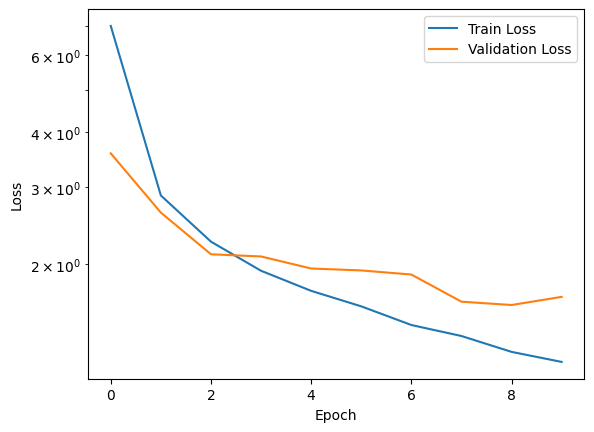

In [24]:
# Note that instance segmentation is harder than semantic segmentation, 
# requiring more data and longer training time per epoch.

# Train for 10 epochs (takes ~90 seconds on GPU)
# This is fewer epochs than semantic segmentation because we have more training data
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    # Training phase
    instance_model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(config.get_device()), targets.to(config.get_device())

        optimizer.zero_grad()
        outputs = instance_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    instance_model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(config.get_device()), targets.to(config.get_device())

            outputs = instance_model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()


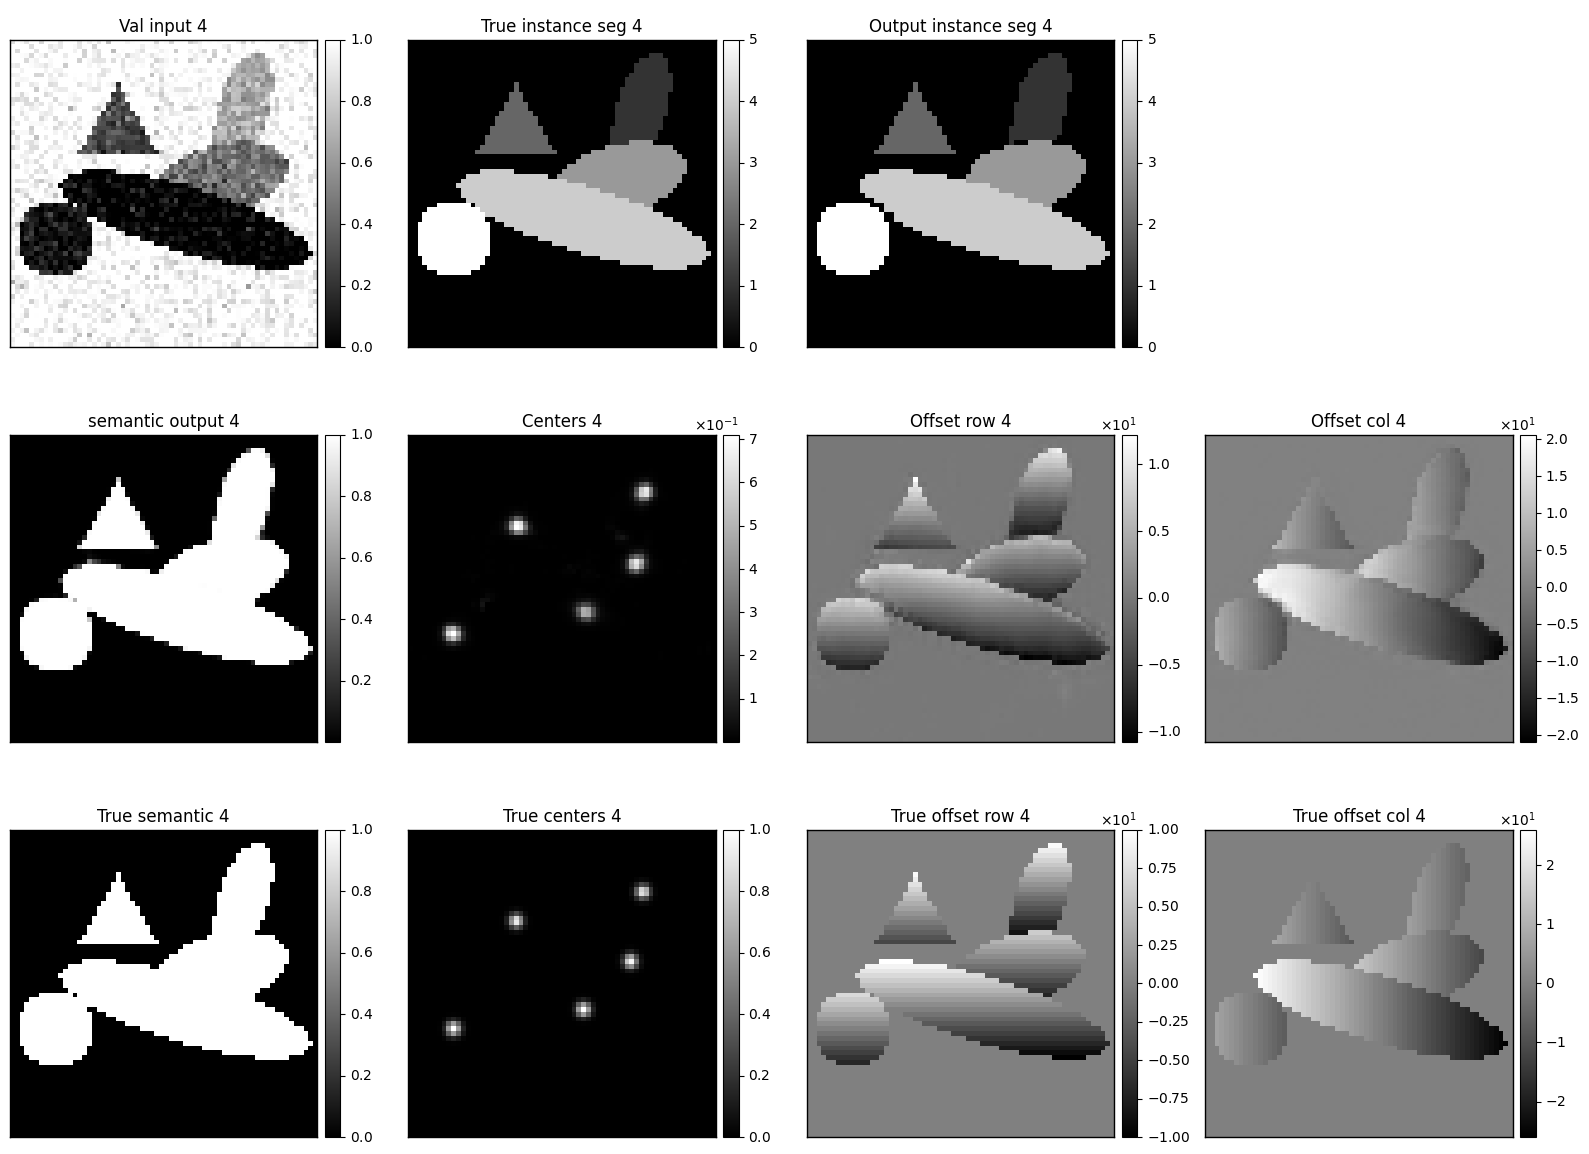

In [25]:
## Evaluate Instance Segmentation

# Test on a validation example and compare different clustering methods
i = 4
thresh_val = 0.5

inp, lab = val_dataset[i]
true_res = dbscan_clustering(lab)  # Cluster ground-truth targets
out = instance_model(inp[None, ...].to(config.get_device())).squeeze().cpu().detach().numpy()

# Try different clustering methods (uncomment to test alternatives):
res = dbscan_clustering(out, semantic_threshold=thresh_val, eps=2)
# res = meanshift_clustering(out, semantic_threshold=thresh_val, bandwidth=5)
# res = watershed_clustering(out, semantic_threshold=thresh_val, center_threshold=0.1)

show_2d(
    [
        [inp.squeeze(),
        true_res,
        res],
        [out[0],
        out[1],
        out[2],
        out[3]],
        [
            lab[0],
            lab[1],
            lab[2],
            lab[3],
        ]
    ],
    cbar=True,
    norm="minmax",
    title=[[f"Val input {i}", f"True instance seg {i}", f"Output instance seg {i}"], [f"semantic output {i}", f"Centers {i}", f"Offset row {i}", f"Offset col {i}"],
        [f"True semantic {i}", f"True centers {i}", f"True offset row {i}", f"True offset col {i}"]],
);


## 2.6 Model saving/loading

If you generate results and do not save the model weights, **that is the same as not saving the raw data--it means your results cannot be reproduced**. 

Besides this, there are other reasons we might want to checkpoint our model during training. 
- Training can be resumed if interrupted 
- The best model might not be the fully trained final model after all epochs 

Here we show how to save the model weights, losses, optimizer state so training can be resumed.

In [26]:
## Save Model Checkpoint

from pathlib import Path
import tempfile

# Create temporary directory for checkpoint
save_dir = Path(tempfile.mkdtemp(prefix="unet_ckpt_"))
ckpt_path = save_dir / "instance_checkpoint.pt"

# Package everything needed to resume training
checkpoint = {
    "epoch": len(train_losses),              # How many epochs we've trained so far
    "model_state": instance_model.state_dict(),     # Model weights
    "optimizer_state": optimizer.state_dict(),      # Optimizer state (momentum, etc.)
    "train_losses": train_losses,            # Training history
    "val_losses": val_losses,
}

# Save to disk
torch.save(checkpoint, ckpt_path)
print(f"Saved checkpoint to {ckpt_path}")


Saved checkpoint to /tmp/unet_ckpt_rb5_qspx/instance_checkpoint.pt


100%|██████████| 4/4 [00:34<00:00,  8.71s/it]


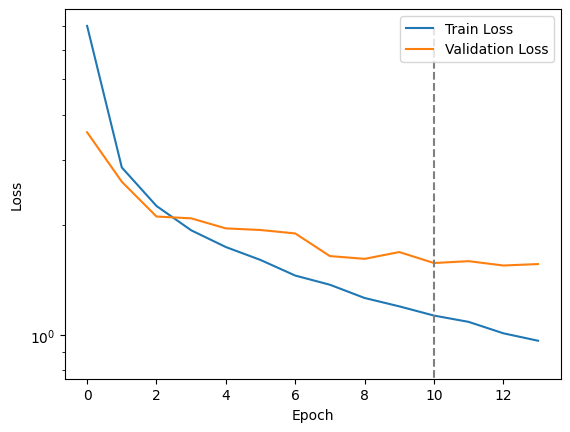

In [27]:
## Load Checkpoint and Resume Training

# Load checkpoint from disk
ckpt = torch.load(ckpt_path, weights_only=False)

# Create fresh model with same architecture
restored_model = MultiChannelCNN2d(
    in_channels=1,
    start_filters=32,
    out_channels=4,
    final_activations=["sigmoid", "sigmoid", "identity", "identity"],
).to(config.get_device())

# Restore weights from checkpoint
restored_model.load_state_dict(ckpt["model_state"])

# Create fresh optimizer and restore its state
restored_optimizer = torch.optim.AdamW(
    restored_model.parameters(), lr=1e-4 * np.sqrt(batch_size)
)
restored_optimizer.load_state_dict(ckpt["optimizer_state"])

# Continue training for 4 more epochs
num_more_epochs = 4
for epoch in tqdm(range(num_more_epochs)):
    restored_model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(config.get_device()), targets.to(config.get_device())
        restored_optimizer.zero_grad()
        outputs = restored_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        restored_optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    restored_model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(config.get_device()), targets.to(config.get_device())
            val_loss += loss_function(restored_model(inputs), targets).item()
        val_losses.append(val_loss / len(val_loader))


fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax.vlines(ckpt["epoch"], 0, np.max(train_losses), color="0.5", linestyle="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()



# Part 3: Deep Image Prior

Here we show how to use a neural network as an image generator for super-resolution. This is primarily intended as a demonstration of how CNNs can be used in a self-supervised learning framework. 

The idea is that instead of training on thousands of examples, we optimize a single network to reconstruct one high-resolution image from its low-resolution version. The network architecture itself acts as a "prior" that favors natural-looking images. The steps are: 

1. Start with a low-resolution image
2. Upsample it to high resolution using bicubic interpolation (blurry but sharper than bilinear)
3. Feed this through the network repeatedly, adjusting weights to minimize difference from the low-res target
4. The network learns to "fill in" missing details in a realistic way

### 3.0 DIP helper functions

In [28]:
import torch.nn.functional as F

def forward_downscale(im: torch.Tensor, factor: int = 2):
    """Downscale image by a factor using bicubic interpolation."""
    return F.interpolate(im, scale_factor=1/factor, mode="bicubic")


def calc_tv_loss(im: torch.Tensor, beta: float = 0.5, weight: float = 1):
    """Calculate Total Variation (TV) loss to encourage smoothness.
    
    TV loss penalizes large differences between neighboring pixels, encouraging
    the network to produce smooth, natural-looking images without sharp artifacts.
    
    Args:
        im: Input image tensor
        beta: Controls smoothness (lower = smoother). See https://arxiv.org/abs/1412.0035
        weight: How strongly to apply this regularization
    
    Returns:
        TV loss value
    """
    if im.ndim == 2:
        im = im[None, None]
    
    # Compute differences with horizontal and vertical neighbors
    dw = (im[..., 1:] - im[..., :-1])**2   # Horizontal differences
    dh = (im[..., 1:, :] - im[..., :-1, :])**2  # Vertical differences
    
    # Sum of squared differences, raised to power beta
    return weight * torch.sum((dw[..., :-1, :] + dh[..., :-1])**beta)

## 3.1 Loading the data

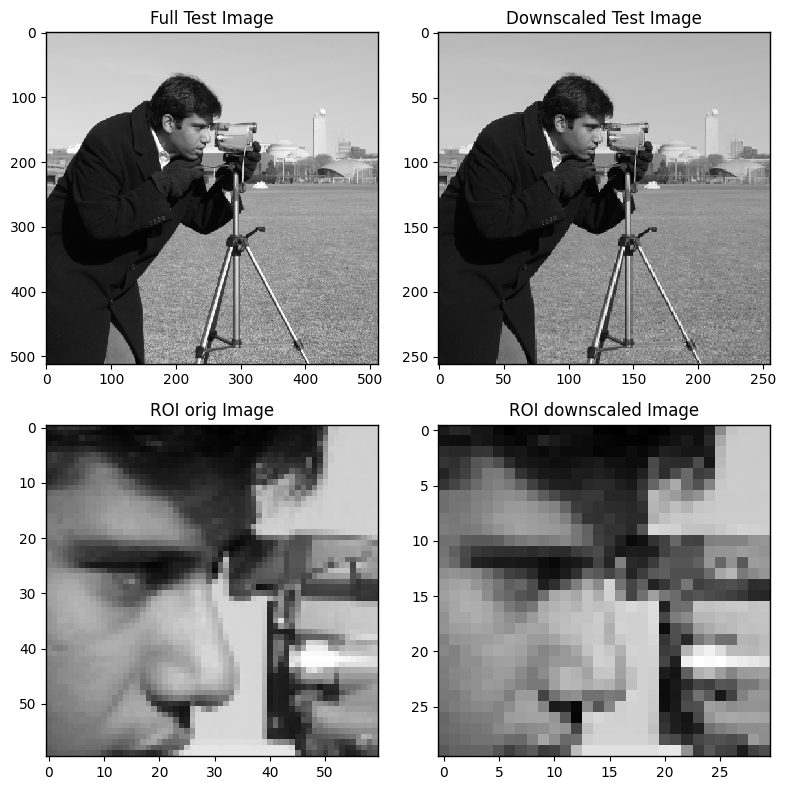

In [29]:
test_im = np.load("../../data/cameraman.npy")

roi_orig = (120, 180, 220, 280)
downscale_factor = 2

downscaled_im = forward_downscale(torch.tensor(test_im)[None, None], factor=downscale_factor).squeeze()

roi_downscaled = (np.array(roi_orig) / downscale_factor).astype(int)

full_res_roi = test_im[roi_orig[0] : roi_orig[1], roi_orig[2] : roi_orig[3]]
downscaled_roi = downscaled_im[
    roi_downscaled[0] : roi_downscaled[1], roi_downscaled[2] : roi_downscaled[3]
]

show_2d(
    [
        [
            test_im,
            downscaled_im,
        ],
        [
            full_res_roi,
            downscaled_roi,
        ],
    ],
    title=[
        ["Full Test Image", "Downscaled Test Image"],
        ["ROI orig Image", "ROI downscaled Image"],
    ],
    norm="minmax",
    show_ticks=True,
);


## 3.1 Setup the DIP

We use a CNN -- 
sigmoid clamp

In [30]:
input_channels = 1
start_filters = 16
num_layers = 3
num_per_layer = 2

dip = CNN2d(
    in_channels=input_channels,
    start_filters=start_filters,
    num_layers=num_layers,
    num_per_layer=num_per_layer,
    use_skip_connections=True,
    dtype=torch.float32,
    dropout=0,
    use_batchnorm=True,
    final_activation="sigmoid",  # Output in [0,1] range
)
dip.to(config.get_device())

# Optimizer and scheduler
optimizer = torch.optim.AdamW([{"params": dip.parameters(), "lr": 1e-3}])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, min_lr=1e-6)

# Track different loss components
fidelity_losses = []  # How well we match the low-res target
tv_losses = []        # Smoothness penalty
total_losses = []     # Combined loss
lrs = []

# Prepare target: downscale the original image
tv_weight = 1e-5  # Weight for TV regularization (small = gentle smoothing)
tv_weight_gamma = 0.999
min_tv_weight = 1e-10
target = downscaled_im.to(config.get_device())[None, None, ...]

# Input: upsample the low-res target back to original size (blurry)
input = torch.nn.functional.interpolate(target, scale_factor=downscale_factor, mode="bicubic")
input = input + 0.01 * torch.randn_like(input)  # Small noise breaks symmetry

# Define regions of interest for visualization
roi_downscaled = (np.array(roi_orig) / downscale_factor).astype(int)


  0%|          | 0/5000 [00:00<?, ?it/s]

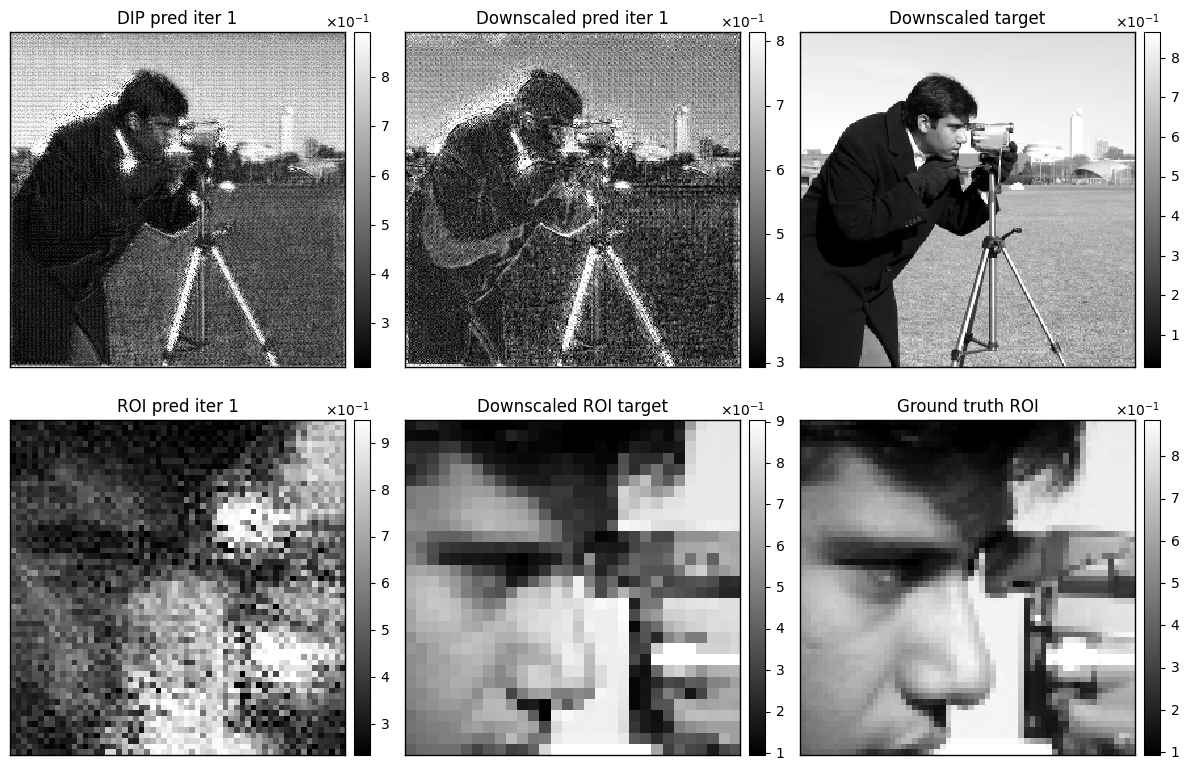

 20%|█▉        | 996/5000 [00:25<01:38, 40.50it/s]

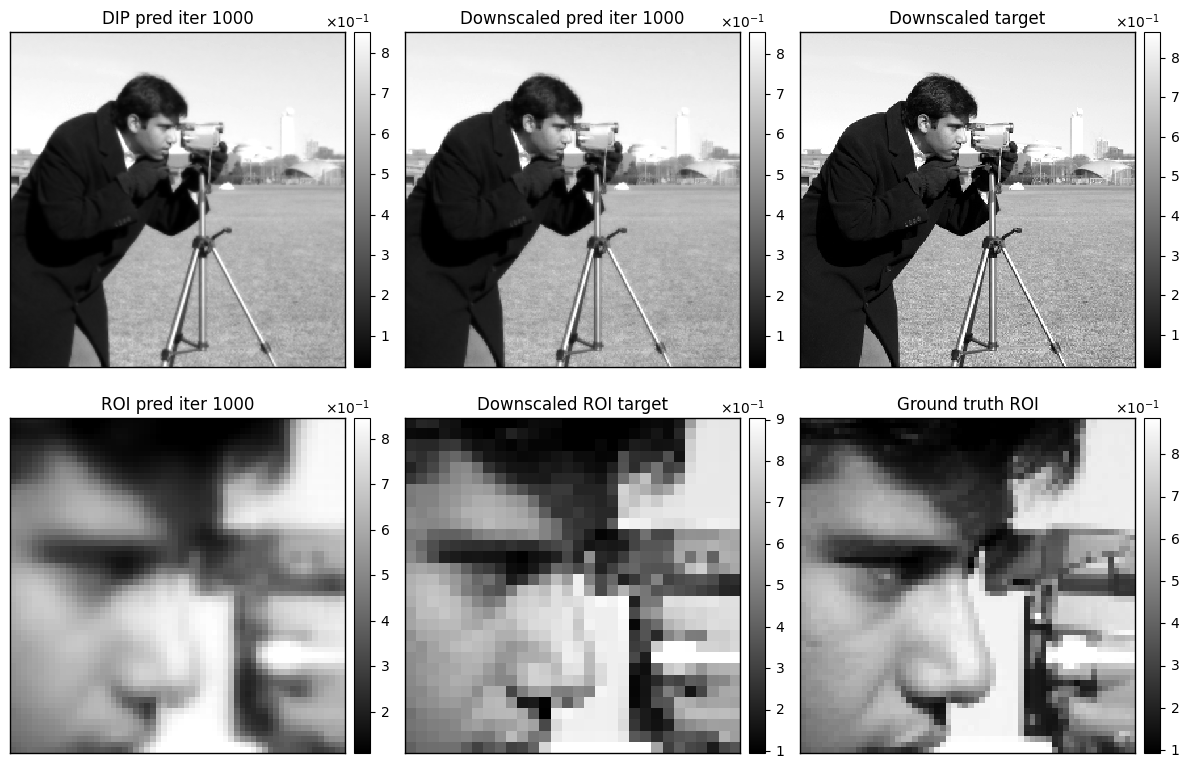

 40%|███▉      | 1997/5000 [00:50<01:14, 40.56it/s]

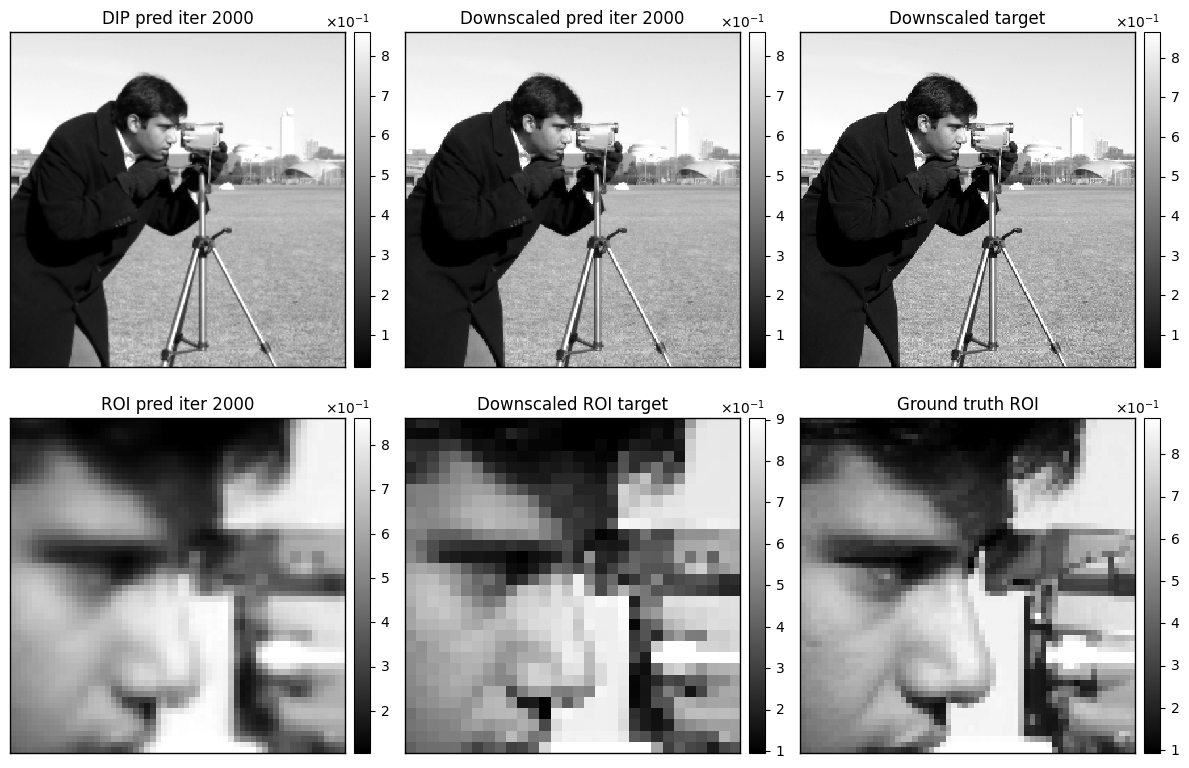

 60%|█████▉    | 2998/5000 [01:15<00:49, 40.65it/s]

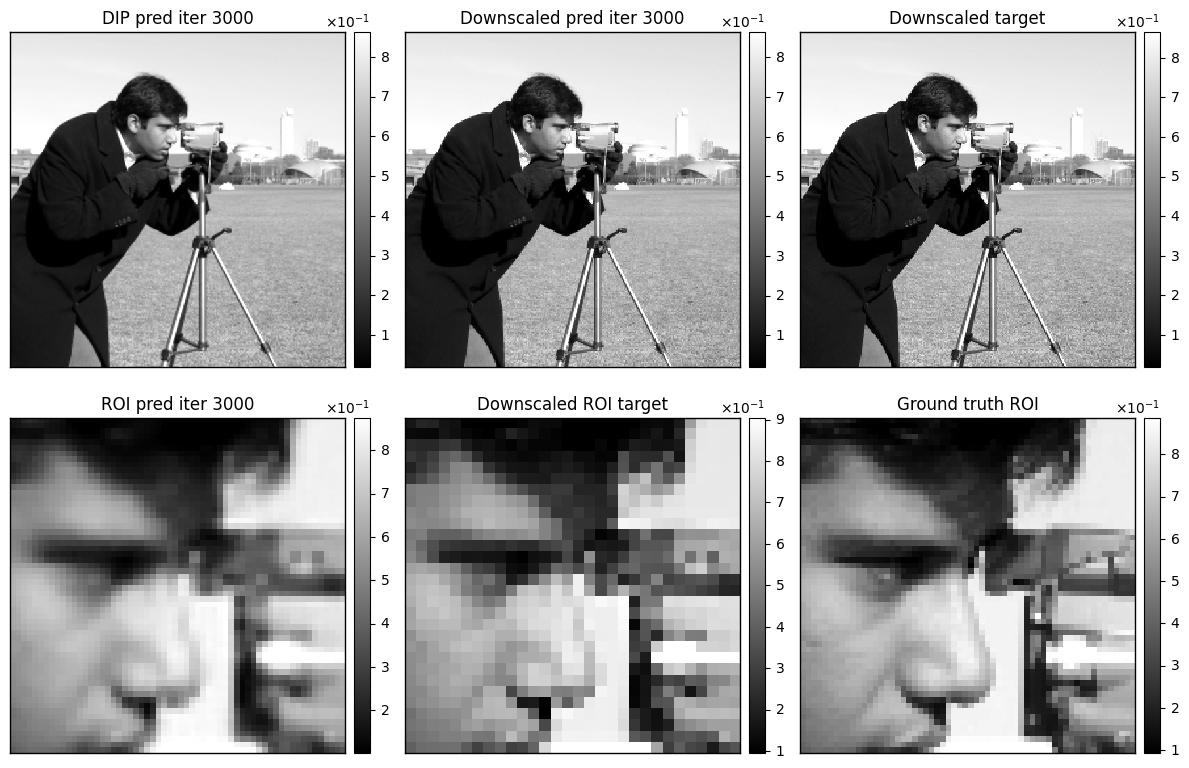

 80%|███████▉  | 3999/5000 [01:40<00:24, 40.88it/s]

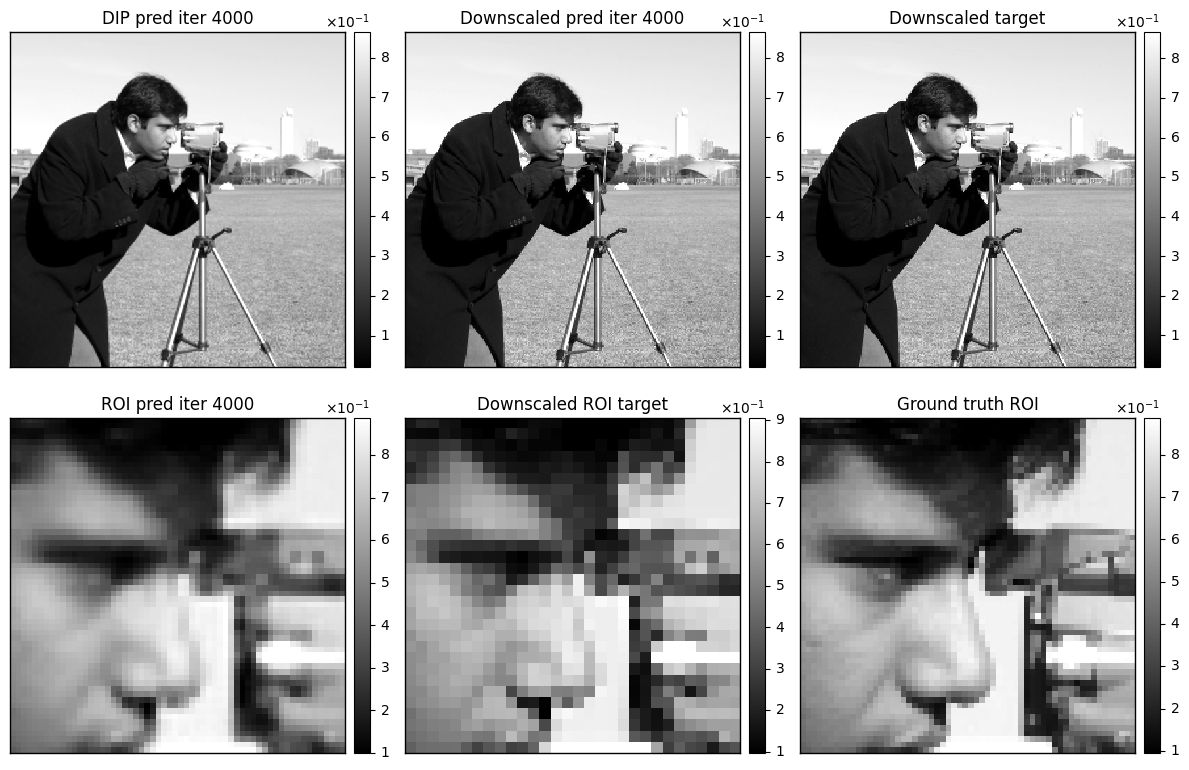

100%|█████████▉| 4995/5000 [02:04<00:00, 42.08it/s]

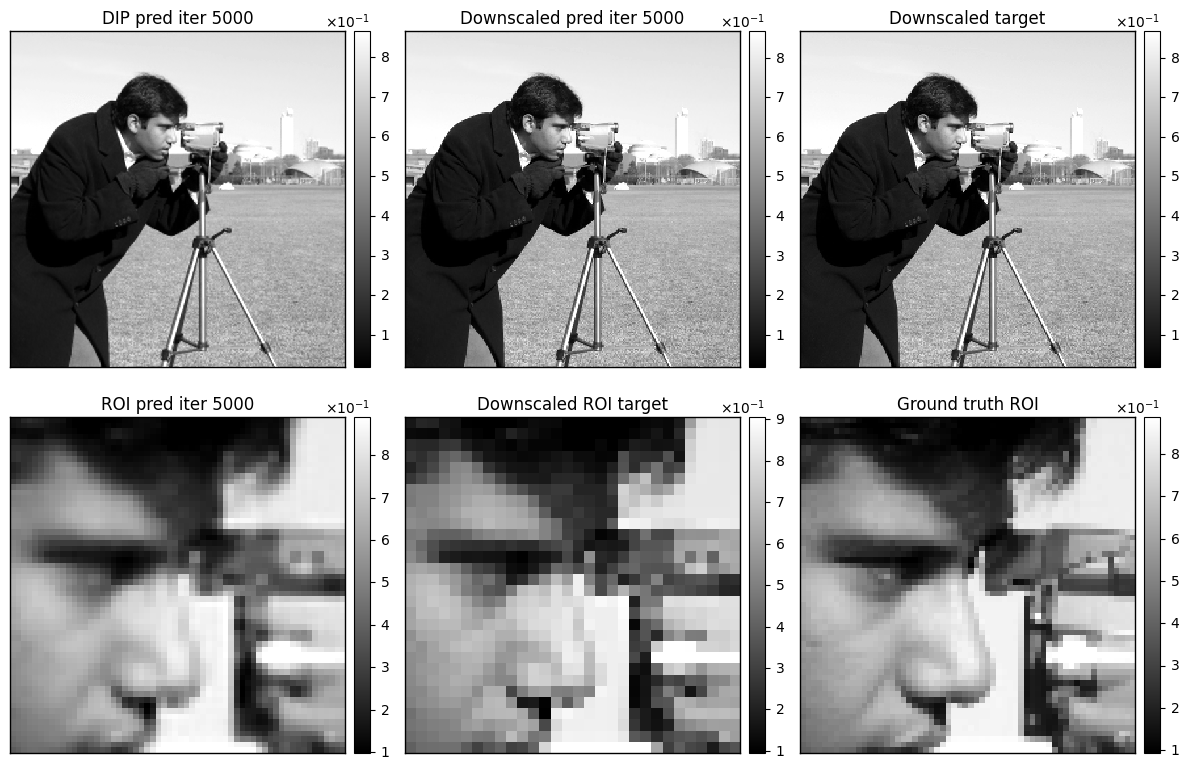

100%|██████████| 5000/5000 [02:05<00:00, 39.85it/s]


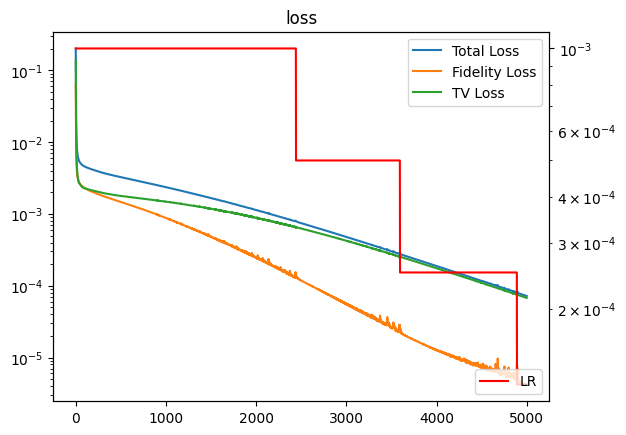

In [31]:
## Train Deep Image Prior
num_epochs = 5000
show_every = 1000

dip.train()
for epoch in tqdm(range(num_epochs)):
    # pred = dip.forward(input).squeeze()
    pred = dip.forward(input + 1e-5 * torch.randn_like(input)).squeeze()
    
    # Downscale prediction to compare with low-res target
    pred_down = forward_downscale(pred[None, None], factor=downscale_factor).squeeze()
    
    # Loss = fidelity (match low-res) + TV regularization (smoothness)
    fidelity_loss = torch.mean((pred_down - target) ** 2)
    tv_weight = max(tv_weight*tv_weight_gamma, min_tv_weight)
    tv_loss = calc_tv_loss(pred, beta=0.9, weight=tv_weight)
    loss = fidelity_loss + tv_loss
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(dip.parameters(), max_norm=1.0) # stabilize training
    optimizer.step()
    
    # Track losses
    fidelity_losses.append(fidelity_loss.item())
    tv_losses.append(tv_loss.item())
    total_losses.append(loss.item())
    lrs.append(optimizer.param_groups[0]['lr'])
    
    # Update learning rate based on loss
    scheduler.step(loss.item())
    
    # Visualize progress
    if epoch == 0 or ((epoch + 1) % show_every == 0):
        with torch.no_grad():
            clean_pred = dip.forward(input).squeeze()  # Generate without noise for visualization
        show_2d(
            [
                [clean_pred.cpu().numpy(),
                pred_down.cpu().detach().numpy(),
                target.cpu().numpy().squeeze(),
                ],
                [
                    clean_pred.cpu().numpy()[roi_orig[0]:roi_orig[1], roi_orig[2]:roi_orig[3]],
                    target.cpu().numpy().squeeze()[roi_downscaled[0]:roi_downscaled[1], roi_downscaled[2]:roi_downscaled[3]],
                    test_im[roi_orig[0]:roi_orig[1], roi_orig[2]:roi_orig[3]],
                ],
            ],
            title=[[f"DIP pred iter {epoch + 1}", f"Downscaled pred iter {epoch + 1}", f"Downscaled target"], 
                   [f"ROI pred iter {epoch + 1}", f"Downscaled ROI target", f"Ground truth ROI"]],
            cbar=True,
            force_show=True,
        )
        plt.show()

fig, ax = plt.subplots()
ax.semilogy(total_losses, label="Total Loss")
ax.semilogy(fidelity_losses, label="Fidelity Loss")
ax.semilogy(tv_losses, label="TV Loss")
ax.legend()
ax.set_title("loss")
ax2 = ax.twinx()
ax2.semilogy(lrs, label="LR", c='r')
ax2.legend(loc='lower right')
plt.show()

dip.eval()
pred = dip.forward(input).squeeze()
plt.close("all")

Running for additional iterations can further improve the result for this case, but DIPs also can have problems with overfitting. 

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Bicubic Interpolation PSNR 30.00 dB'}>,
        <Axes: title={'center': 'Deep Image Prior PSNR 30.09 dB'}>,
        <Axes: title={'center': 'Ground Truth'}>], dtype=object))

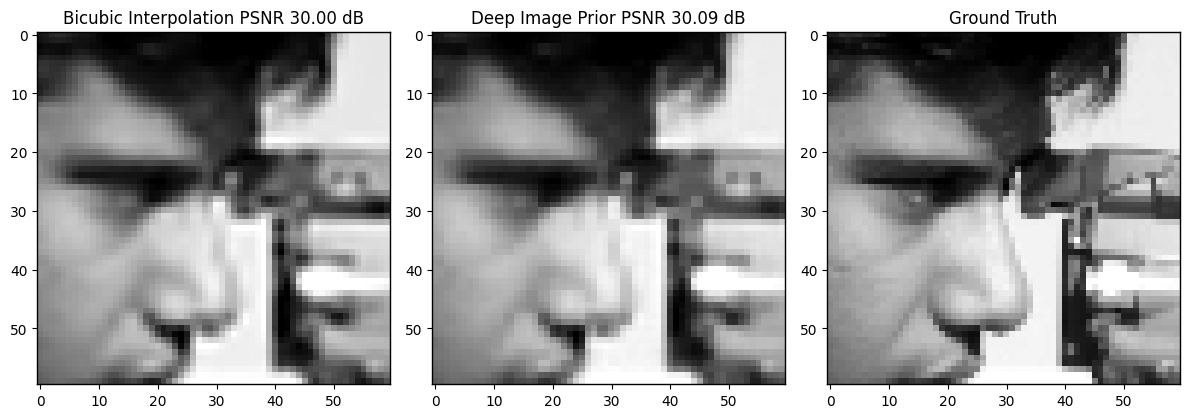

In [32]:
## Compare Results
from skimage.metrics import peak_signal_noise_ratio as psnr

# Compare simple bicubic upsampling vs our neural network with the ground truth
bicubic = torch.nn.functional.interpolate(target, scale_factor=downscale_factor, mode="bicubic").squeeze().cpu().detach().numpy()
pred_np = pred.squeeze().cpu().detach().numpy()
psnr_bicubic = psnr(test_im, bicubic, data_range=test_im.max() - test_im.min())
psnr_pred = psnr(test_im, pred_np, data_range=test_im.max() - test_im.min())

show_2d(
    [
        bicubic[roi_orig[0] : roi_orig[1], roi_orig[2] : roi_orig[3]],
        pred_np[roi_orig[0] : roi_orig[1], roi_orig[2] : roi_orig[3]],
        test_im[roi_orig[0] : roi_orig[1], roi_orig[2] : roi_orig[3]],
    ],
    title=[f"Bicubic Interpolation PSNR {psnr_bicubic:.2f} dB", f"Deep Image Prior PSNR {psnr_pred:.2f} dB", "Ground Truth"],
    show_ticks=True,
)


-- end -- 